In [10]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.utils import to_categorical
import pandas as pd
import librosa
import os
import pathlib
import matplotlib.pyplot as plt
from pathlib import Path

from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [11]:
LEN_SONG = 660000
NUM_SONGS = 500
DATA_PATH = Path('../data/raw/genres/')

In [27]:
# # Feature dimension
feature_dim_1 = 20
channel = 1
epochs = 500
batch_size = 100
verbose = 1
num_classes = 10
feature_dim_2 = 11

In [80]:
# Handy function to convert wav2mfcc
def wav2mfcc(file_path, max_len=11):
    wave, sr = librosa.load(file_path, mono=True, sr=16000)
    wave = wave[::3]
    wave = np.asfortranarray(wave)
    mfcc = librosa.feature.melspectrogram(wave, sr=16000)

    # If maximum length exceeds mfcc lengths then pad the remaining ones
    if (max_len > mfcc.shape[1]):
        pad_width = max_len - mfcc.shape[1]
        mfcc = np.pad(mfcc, pad_width=((0, 0), (0, pad_width)), mode='constant')

    # Else cutoff the remaining parts
    else:
        mfcc = mfcc[:, :max_len]

    return mfcc

# Input: Folder Path
# Output: Tuple (Label, Indices of the labels)
def get_labels(path=DATA_PATH):
    labels = [x for x in path.iterdir() if x.is_dir()]
    label_indices = np.arange(0, len(labels))
    return labels, label_indices

def save_data_to_array(path=DATA_PATH, max_len=11):
    labels, _= get_labels(path)

    for label in labels:
        # Init mfcc vectors
        mfcc_vectors = []

        wavfiles = [wavfile for wavfile in label.glob('*.wav') if wavfile.is_file()]
        for wavfile in tqdm(wavfiles, "Saving vectors of label - '{}'".format(label)):
            mfcc = wav2mfcc(wavfile, max_len=max_len)
            mfcc_vectors.append(mfcc)
        np.save(label / '.npy', mfcc_vectors)
        
def get_train_test(split_ratio=0.6):
    # Get available labels
    labels, indices= get_labels(DATA_PATH)

    print(labels)
    # Getting first arrays
    X = np.load(labels[0].name + '.npy')
    y = np.zeros(X.shape[0])

    # Append all of the dataset into one single array, same goes for y
    for i, label in enumerate(labels[1:]):
        x = np.load(label.name + '.npy')
        X = np.vstack((X, x))
        y = np.append(y, np.full(x.shape[0], fill_value= (i + 1)))

    assert X.shape[0] == len(y)

    return train_test_split(X, y, test_size= (1 - split_ratio), random_state=42, shuffle=True)

In [42]:
# Second dimension of the feature is dim2
#feature_dim_2 = 13

# Save data to array file first
save_data_to_array(max_len=feature_dim_2)

Saving vectors of label - '../data/raw/genres/pop': 100%|██████████| 100/100 [00:52<00:00,  1.90it/s]
Saving vectors of label - '../data/raw/genres/metal': 100%|██████████| 100/100 [00:52<00:00,  1.92it/s]
Saving vectors of label - '../data/raw/genres/disco': 100%|██████████| 100/100 [00:52<00:00,  1.92it/s]
Saving vectors of label - '../data/raw/genres/blues':  62%|██████▏   | 62/100 [00:32<00:20,  1.83it/s]

KeyboardInterrupt: 

In [96]:
# # Loading train set and test set
X_train, X_valid, y_train, y_valid = get_train_test()

X_train = X_train.reshape(X_train.shape[0], feature_dim_1, feature_dim_2, channel)
X_valid = X_valid.reshape(X_valid.shape[0], feature_dim_1, feature_dim_2, channel)

[PosixPath('../data/raw/genres/pop'), PosixPath('../data/raw/genres/metal'), PosixPath('../data/raw/genres/disco'), PosixPath('../data/raw/genres/blues'), PosixPath('../data/raw/genres/reggae'), PosixPath('../data/raw/genres/classical'), PosixPath('../data/raw/genres/rock'), PosixPath('../data/raw/genres/hiphop'), PosixPath('../data/raw/genres/country'), PosixPath('../data/raw/genres/jazz')]


In [97]:
X_train.shape

(600, 20, 11, 1)

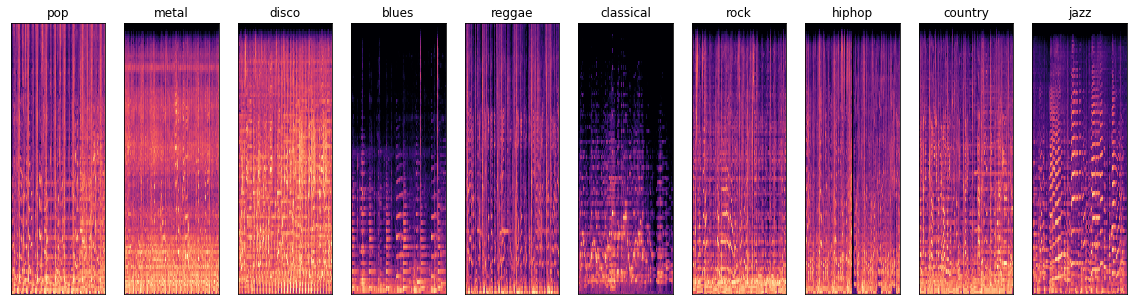

In [98]:
import librosa
import librosa.display
import numpy as np
import pylab


# plot first six training songs
fig = plt.figure(figsize=(20,5))

labels, _= get_labels(DATA_PATH)

for i, label in enumerate(labels):
    ax = fig.add_subplot(1, len(labels), i+1)
    wavfiles = [wavfile for wavfile in label.glob('*.wav') if wavfile.is_file()]
    sig, fs = librosa.load(wavfiles[0])   

    S = librosa.feature.melspectrogram(y=sig, sr=16000)
    librosa.display.specshow(librosa.power_to_db(S, ref=np.max))
    ax.set_title(str(label.name))


In [99]:
y_train_hot = to_categorical(y_train)
y_valid_hot = to_categorical(y_valid)

In [100]:
from tensorflow.keras.layers import Dense, Activation, Conv1D, Conv2D, Input, Dropout, \
    Flatten, InputLayer, MaxPool2D, GlobalAveragePooling2D, MaxPool1D, MaxPooling2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import regularizers

# Predicts one sample
def predict(filepath, model):
    sample = wav2mfcc(filepath)
    sample_reshaped = sample.reshape(1, feature_dim_1, feature_dim_2, channel)
    return get_labels()[0][
            np.argmax(model.predict(sample_reshaped))
    ]

In [101]:
def conv_block(x, n_filters, pool_size=(2, 2)):
    x = Conv2D(n_filters, (3, 3), strides=(1, 1), padding='same', kernel_regularizer=regularizers.l2(0.01))(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=pool_size, strides=pool_size)(x)
    x = Dropout(0.5)(x)
    return x

# Model Definition
def create_model(input_shape, num_genres):
    inpt = Input(shape=input_shape)
    x = conv_block(inpt, 32)
    x = conv_block(x, 64)
    
    # Global Pooling and MLP
    x = Flatten()(x)
    x = Dropout(0.5)(x)
    x = Dense(512, activation='relu', 
              kernel_regularizer=tf.keras.regularizers.l2(0.02))(x)
    x = Dropout(0.25)(x)
    predictions = Dense(num_genres, 
                        activation='softmax', 
                        kernel_regularizer=tf.keras.regularizers.l2(0.02))(x)
    
    model = Model(inputs=inpt, outputs=predictions)
    model.compile(loss='categorical_crossentropy',
                  optimizer='RMSProp',
                  metrics=['accuracy'])
    return model


In [102]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

callbacks = [
    ModelCheckpoint(filepath='tagger3.model.best.hdf5', 
                               verbose=1, save_best_only=True),

    

ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.95,
    patience=3,
    verbose=1,
    mode='min',
    min_delta=0.0001,
    cooldown=2,
    min_lr=1e-5
)


]
tf.keras.callbacks.EarlyStopping(
# Stop training when `val_loss` is no longer improving
monitor='val_loss',
# "no longer improving" being defined as "no better than 1e-2 less"
min_delta=1e-3,
# "no longer improving" being further defined as "for at least 2 epochs"
patience=4,
verbose=1),


(<tensorflow.python.keras.callbacks.EarlyStopping at 0x148b0e908>,)

In [103]:
model = create_model((feature_dim_1, feature_dim_2, channel), 10)
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 20, 11, 1)]       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 20, 11, 32)        320       
_________________________________________________________________
activation_2 (Activation)    (None, 20, 11, 32)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 10, 5, 32)         0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 10, 5, 32)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 10, 5, 64)         18496     
_________________________________________________________________
activation_3 (Activation)    (None, 10, 5, 64)         0   

In [104]:
hist = model.fit(X_train, y_train_hot, epochs=epochs,
          callbacks=callbacks,
          verbose=verbose, validation_split=0.2)

Train on 480 samples, validate on 120 samples
Epoch 1/500
352/480 [=====================>........] - ETA: 0s - loss: 31.8443 - accuracy: 0.0909
Epoch 00001: val_loss improved from inf to 14.23184, saving model to tagger3.model.best.hdf5
480/480 [==============================] - 1s 2ms/sample - loss: 28.9725 - accuracy: 0.1063 - val_loss: 14.2318 - val_accuracy: 0.1417
Epoch 2/500
320/480 [===================>..........] - ETA: 0s - loss: 19.8138 - accuracy: 0.1312
Epoch 00002: val_loss improved from 14.23184 to 13.37426, saving model to tagger3.model.best.hdf5
480/480 [==============================] - 0s 452us/sample - loss: 18.8616 - accuracy: 0.1333 - val_loss: 13.3743 - val_accuracy: 0.2500
Epoch 3/500
384/480 [=======================>......] - ETA: 0s - loss: 15.1924 - accuracy: 0.1380
Epoch 00003: val_loss improved from 13.37426 to 12.74745, saving model to tagger3.model.best.hdf5
480/480 [==============================] - 0s 516us/sample - loss: 14.9969 - accuracy: 0.1437 - val

Epoch 26/500
320/480 [===================>..........] - ETA: 0s - loss: 2.5609 - accuracy: 0.2500
Epoch 00026: val_loss improved from 2.57772 to 2.55485, saving model to tagger3.model.best.hdf5
480/480 [==============================] - 0s 454us/sample - loss: 2.5592 - accuracy: 0.2458 - val_loss: 2.5549 - val_accuracy: 0.2417
Epoch 27/500
352/480 [=====================>........] - ETA: 0s - loss: 2.5215 - accuracy: 0.2955
Epoch 00027: val_loss improved from 2.55485 to 2.54175, saving model to tagger3.model.best.hdf5
480/480 [==============================] - 0s 425us/sample - loss: 2.5360 - accuracy: 0.2729 - val_loss: 2.5417 - val_accuracy: 0.2167
Epoch 28/500
352/480 [=====================>........] - ETA: 0s - loss: 2.4230 - accuracy: 0.2784
Epoch 00028: val_loss improved from 2.54175 to 2.48280, saving model to tagger3.model.best.hdf5
480/480 [==============================] - 0s 473us/sample - loss: 2.4557 - accuracy: 0.2833 - val_loss: 2.4828 - val_accuracy: 0.2833
Epoch 29/500


Epoch 52/500
352/480 [=====================>........] - ETA: 0s - loss: 2.1425 - accuracy: 0.3466
Epoch 00052: val_loss improved from 2.21671 to 2.20223, saving model to tagger3.model.best.hdf5
480/480 [==============================] - 0s 428us/sample - loss: 2.1381 - accuracy: 0.3500 - val_loss: 2.2022 - val_accuracy: 0.3417
Epoch 53/500
448/480 [===========================>..] - ETA: 0s - loss: 2.1441 - accuracy: 0.3504
Epoch 00053: val_loss did not improve from 2.20223
480/480 [==============================] - 0s 458us/sample - loss: 2.1447 - accuracy: 0.3542 - val_loss: 2.2576 - val_accuracy: 0.3000
Epoch 54/500
352/480 [=====================>........] - ETA: 0s - loss: 2.0993 - accuracy: 0.3693
Epoch 00054: val_loss did not improve from 2.20223
480/480 [==============================] - 0s 420us/sample - loss: 2.1301 - accuracy: 0.3667 - val_loss: 2.2053 - val_accuracy: 0.3083
Epoch 55/500
448/480 [===========================>..] - ETA: 0s - loss: 2.1421 - accuracy: 0.3527 ETA: 

Epoch 79/500
416/480 [=========================>....] - ETA: 0s - loss: 2.0373 - accuracy: 0.3702
Epoch 00079: val_loss improved from 2.12921 to 2.11901, saving model to tagger3.model.best.hdf5
480/480 [==============================] - 0s 480us/sample - loss: 2.0078 - accuracy: 0.3875 - val_loss: 2.1190 - val_accuracy: 0.3417
Epoch 80/500
352/480 [=====================>........] - ETA: 0s - loss: 1.9544 - accuracy: 0.4062
Epoch 00080: val_loss did not improve from 2.11901
480/480 [==============================] - 0s 356us/sample - loss: 1.9795 - accuracy: 0.3958 - val_loss: 2.1468 - val_accuracy: 0.3167
Epoch 81/500
384/480 [=======================>......] - ETA: 0s - loss: 1.8930 - accuracy: 0.4609
Epoch 00081: val_loss improved from 2.11901 to 2.11544, saving model to tagger3.model.best.hdf5
480/480 [==============================] - 0s 422us/sample - loss: 1.9357 - accuracy: 0.4417 - val_loss: 2.1154 - val_accuracy: 0.3500
Epoch 82/500
416/480 [=========================>....] - ET

Epoch 106/500
352/480 [=====================>........] - ETA: 0s - loss: 1.9282 - accuracy: 0.4460
Epoch 00106: val_loss did not improve from 2.08271
480/480 [==============================] - 0s 431us/sample - loss: 1.9258 - accuracy: 0.4479 - val_loss: 2.0845 - val_accuracy: 0.3500
Epoch 107/500
352/480 [=====================>........] - ETA: 0s - loss: 1.8166 - accuracy: 0.4631
Epoch 00107: val_loss did not improve from 2.08271

Epoch 00107: ReduceLROnPlateau reducing learning rate to 0.0005987368611386045.
480/480 [==============================] - 0s 400us/sample - loss: 1.8285 - accuracy: 0.4604 - val_loss: 2.1785 - val_accuracy: 0.3333
Epoch 108/500
352/480 [=====================>........] - ETA: 0s - loss: 1.8113 - accuracy: 0.5085
Epoch 00108: val_loss did not improve from 2.08271
480/480 [==============================] - 0s 366us/sample - loss: 1.8457 - accuracy: 0.4792 - val_loss: 2.1083 - val_accuracy: 0.3667
Epoch 109/500
320/480 [===================>..........] - ETA: 0s

Epoch 133/500
448/480 [===========================>..] - ETA: 0s - loss: 1.8192 - accuracy: 0.4710
Epoch 00133: val_loss did not improve from 2.04947
480/480 [==============================] - 0s 423us/sample - loss: 1.8052 - accuracy: 0.4729 - val_loss: 2.0945 - val_accuracy: 0.3333
Epoch 134/500
384/480 [=======================>......] - ETA: 0s - loss: 1.7272 - accuracy: 0.5000
Epoch 00134: val_loss did not improve from 2.04947
480/480 [==============================] - 0s 359us/sample - loss: 1.7528 - accuracy: 0.5042 - val_loss: 2.0837 - val_accuracy: 0.3333
Epoch 135/500
352/480 [=====================>........] - ETA: 0s - loss: 1.6648 - accuracy: 0.5483
Epoch 00135: val_loss did not improve from 2.04947
480/480 [==============================] - 0s 360us/sample - loss: 1.7023 - accuracy: 0.5333 - val_loss: 2.0596 - val_accuracy: 0.3583
Epoch 136/500
416/480 [=========================>....] - ETA: 0s - loss: 1.7271 - accuracy: 0.5048
Epoch 00136: val_loss did not improve from 2.0

Epoch 160/500
448/480 [===========================>..] - ETA: 0s - loss: 1.7420 - accuracy: 0.5179
Epoch 00160: val_loss did not improve from 2.04611
480/480 [==============================] - 0s 423us/sample - loss: 1.7353 - accuracy: 0.5188 - val_loss: 2.1207 - val_accuracy: 0.3500
Epoch 161/500
448/480 [===========================>..] - ETA: 0s - loss: 1.6365 - accuracy: 0.5513
Epoch 00161: val_loss did not improve from 2.04611
480/480 [==============================] - 0s 448us/sample - loss: 1.6283 - accuracy: 0.5479 - val_loss: 2.0903 - val_accuracy: 0.3583
Epoch 162/500
352/480 [=====================>........] - ETA: 0s - loss: 1.7058 - accuracy: 0.5170
Epoch 00162: val_loss did not improve from 2.04611

Epoch 00162: ReduceLROnPlateau reducing learning rate to 0.00032353347924072293.
480/480 [==============================] - 0s 389us/sample - loss: 1.7371 - accuracy: 0.5104 - val_loss: 2.1211 - val_accuracy: 0.3167
Epoch 163/500
352/480 [=====================>........] - ETA: 0

Epoch 187/500
448/480 [===========================>..] - ETA: 0s - loss: 1.5789 - accuracy: 0.5625
Epoch 00187: val_loss did not improve from 2.04611
480/480 [==============================] - 0s 441us/sample - loss: 1.5630 - accuracy: 0.5688 - val_loss: 2.0529 - val_accuracy: 0.3583
Epoch 188/500
352/480 [=====================>........] - ETA: 0s - loss: 1.5348 - accuracy: 0.5767
Epoch 00188: val_loss did not improve from 2.04611
480/480 [==============================] - 0s 388us/sample - loss: 1.5585 - accuracy: 0.5667 - val_loss: 2.0756 - val_accuracy: 0.3333
Epoch 189/500
320/480 [===================>..........] - ETA: 0s - loss: 1.6848 - accuracy: 0.5156
Epoch 00189: val_loss did not improve from 2.04611
480/480 [==============================] - 0s 419us/sample - loss: 1.6226 - accuracy: 0.5458 - val_loss: 2.0940 - val_accuracy: 0.3250
Epoch 190/500
352/480 [=====================>........] - ETA: 0s - loss: 1.5599 - accuracy: 0.5341
Epoch 00190: val_loss did not improve from 2.0

448/480 [===========================>..] - ETA: 0s - loss: 1.5796 - accuracy: 0.5625
Epoch 00214: val_loss did not improve from 2.04611

Epoch 00214: ReduceLROnPlateau reducing learning rate to 0.0001660833557252772.
480/480 [==============================] - 0s 447us/sample - loss: 1.5749 - accuracy: 0.5604 - val_loss: 2.0864 - val_accuracy: 0.3583
Epoch 215/500
352/480 [=====================>........] - ETA: 0s - loss: 1.5645 - accuracy: 0.5625
Epoch 00215: val_loss did not improve from 2.04611
480/480 [==============================] - 0s 373us/sample - loss: 1.5753 - accuracy: 0.5625 - val_loss: 2.0841 - val_accuracy: 0.3667
Epoch 216/500
384/480 [=======================>......] - ETA: 0s - loss: 1.4900 - accuracy: 0.6042
Epoch 00216: val_loss did not improve from 2.04611
480/480 [==============================] - 0s 359us/sample - loss: 1.5082 - accuracy: 0.6062 - val_loss: 2.0779 - val_accuracy: 0.3500
Epoch 217/500
352/480 [=====================>........] - ETA: 0s - loss: 1.600

Epoch 241/500
448/480 [===========================>..] - ETA: 0s - loss: 1.4914 - accuracy: 0.5938
Epoch 00241: val_loss did not improve from 2.04611
480/480 [==============================] - 0s 429us/sample - loss: 1.4834 - accuracy: 0.5958 - val_loss: 2.0676 - val_accuracy: 0.3417
Epoch 242/500
384/480 [=======================>......] - ETA: 0s - loss: 1.4272 - accuracy: 0.6276
Epoch 00242: val_loss did not improve from 2.04611

Epoch 00242: ReduceLROnPlateau reducing learning rate to 0.00011598219716688617.
480/480 [==============================] - 0s 378us/sample - loss: 1.4746 - accuracy: 0.6042 - val_loss: 2.0595 - val_accuracy: 0.3417
Epoch 243/500
448/480 [===========================>..] - ETA: 0s - loss: 1.5070 - accuracy: 0.5804
Epoch 00243: val_loss did not improve from 2.04611
480/480 [==============================] - 0s 426us/sample - loss: 1.5045 - accuracy: 0.5833 - val_loss: 2.0914 - val_accuracy: 0.3333
Epoch 244/500
320/480 [===================>..........] - ETA: 0

Epoch 268/500
384/480 [=======================>......] - ETA: 0s - loss: 1.4829 - accuracy: 0.5833
Epoch 00268: val_loss did not improve from 2.04611
480/480 [==============================] - 0s 360us/sample - loss: 1.4858 - accuracy: 0.5833 - val_loss: 2.0759 - val_accuracy: 0.3333
Epoch 269/500
320/480 [===================>..........] - ETA: 0s - loss: 1.5319 - accuracy: 0.5844
Epoch 00269: val_loss did not improve from 2.04611
480/480 [==============================] - 0s 385us/sample - loss: 1.5153 - accuracy: 0.5750 - val_loss: 2.0825 - val_accuracy: 0.3333
Epoch 270/500
416/480 [=========================>....] - ETA: 0s - loss: 1.4697 - accuracy: 0.5986
Epoch 00270: val_loss did not improve from 2.04611

Epoch 00270: ReduceLROnPlateau reducing learning rate to 8.099469014268834e-05.
480/480 [==============================] - 0s 341us/sample - loss: 1.4642 - accuracy: 0.6042 - val_loss: 2.0885 - val_accuracy: 0.3417
Epoch 271/500
416/480 [=========================>....] - ETA: 0s

Epoch 295/500
416/480 [=========================>....] - ETA: 0s - loss: 1.4777 - accuracy: 0.5817
Epoch 00295: val_loss did not improve from 2.04611
480/480 [==============================] - 0s 344us/sample - loss: 1.4782 - accuracy: 0.5833 - val_loss: 2.0853 - val_accuracy: 0.3333
Epoch 296/500
384/480 [=======================>......] - ETA: 0s - loss: 1.5131 - accuracy: 0.5911
Epoch 00296: val_loss did not improve from 2.04611
480/480 [==============================] - 0s 360us/sample - loss: 1.4879 - accuracy: 0.5979 - val_loss: 2.0823 - val_accuracy: 0.3333
Epoch 297/500
352/480 [=====================>........] - ETA: 0s - loss: 1.4245 - accuracy: 0.6165
Epoch 00297: val_loss did not improve from 2.04611
480/480 [==============================] - 0s 362us/sample - loss: 1.4367 - accuracy: 0.6208 - val_loss: 2.0914 - val_accuracy: 0.3417
Epoch 298/500
384/480 [=======================>......] - ETA: 0s - loss: 1.4897 - accuracy: 0.5938
Epoch 00298: val_loss did not improve from 2.0

416/480 [=========================>....] - ETA: 0s - loss: 1.3825 - accuracy: 0.6538
Epoch 00322: val_loss did not improve from 2.04611

Epoch 00322: ReduceLROnPlateau reducing learning rate to 4.1577981755835934e-05.
480/480 [==============================] - 0s 336us/sample - loss: 1.3978 - accuracy: 0.6375 - val_loss: 2.0817 - val_accuracy: 0.3583
Epoch 323/500
352/480 [=====================>........] - ETA: 0s - loss: 1.4673 - accuracy: 0.6278
Epoch 00323: val_loss did not improve from 2.04611
480/480 [==============================] - 0s 357us/sample - loss: 1.4580 - accuracy: 0.6313 - val_loss: 2.0830 - val_accuracy: 0.3500
Epoch 324/500
416/480 [=========================>....] - ETA: 0s - loss: 1.3907 - accuracy: 0.6394
Epoch 00324: val_loss did not improve from 2.04611
480/480 [==============================] - 0s 345us/sample - loss: 1.4274 - accuracy: 0.6313 - val_loss: 2.0943 - val_accuracy: 0.3500
Epoch 325/500
416/480 [=========================>....] - ETA: 0s - loss: 1.44

Epoch 349/500
416/480 [=========================>....] - ETA: 0s - loss: 1.3982 - accuracy: 0.6154
Epoch 00349: val_loss did not improve from 2.04611
480/480 [==============================] - 0s 345us/sample - loss: 1.4422 - accuracy: 0.6000 - val_loss: 2.0881 - val_accuracy: 0.3417
Epoch 350/500
416/480 [=========================>....] - ETA: 0s - loss: 1.4273 - accuracy: 0.6154
Epoch 00350: val_loss did not improve from 2.04611

Epoch 00350: ReduceLROnPlateau reducing learning rate to 2.9035460102022626e-05.
480/480 [==============================] - 0s 346us/sample - loss: 1.4391 - accuracy: 0.6104 - val_loss: 2.0814 - val_accuracy: 0.3417
Epoch 351/500
384/480 [=======================>......] - ETA: 0s - loss: 1.3674 - accuracy: 0.6458
Epoch 00351: val_loss did not improve from 2.04611
480/480 [==============================] - 0s 347us/sample - loss: 1.4025 - accuracy: 0.6271 - val_loss: 2.0800 - val_accuracy: 0.3417
Epoch 352/500
416/480 [=========================>....] - ETA: 0

Epoch 376/500
384/480 [=======================>......] - ETA: 0s - loss: 1.3861 - accuracy: 0.6354
Epoch 00376: val_loss did not improve from 2.04611
480/480 [==============================] - 0s 353us/sample - loss: 1.3748 - accuracy: 0.6375 - val_loss: 2.0826 - val_accuracy: 0.3417
Epoch 377/500
384/480 [=======================>......] - ETA: 0s - loss: 1.4029 - accuracy: 0.6380
Epoch 00377: val_loss did not improve from 2.04611
480/480 [==============================] - 0s 346us/sample - loss: 1.4205 - accuracy: 0.6271 - val_loss: 2.0777 - val_accuracy: 0.3417
Epoch 378/500
352/480 [=====================>........] - ETA: 0s - loss: 1.4272 - accuracy: 0.6193
Epoch 00378: val_loss did not improve from 2.04611

Epoch 00378: ReduceLROnPlateau reducing learning rate to 2.0276544091757387e-05.
480/480 [==============================] - 0s 353us/sample - loss: 1.4384 - accuracy: 0.6083 - val_loss: 2.0775 - val_accuracy: 0.3417
Epoch 379/500
416/480 [=========================>....] - ETA: 0

Epoch 403/500
352/480 [=====================>........] - ETA: 0s - loss: 1.3619 - accuracy: 0.6449
Epoch 00403: val_loss did not improve from 2.04611
480/480 [==============================] - 0s 365us/sample - loss: 1.3729 - accuracy: 0.6333 - val_loss: 2.0904 - val_accuracy: 0.3417
Epoch 404/500
416/480 [=========================>....] - ETA: 0s - loss: 1.4239 - accuracy: 0.6082
Epoch 00404: val_loss did not improve from 2.04611
480/480 [==============================] - 0s 338us/sample - loss: 1.4309 - accuracy: 0.6042 - val_loss: 2.0926 - val_accuracy: 0.3417
Epoch 405/500
352/480 [=====================>........] - ETA: 0s - loss: 1.3828 - accuracy: 0.6392
Epoch 00405: val_loss did not improve from 2.04611
480/480 [==============================] - 0s 355us/sample - loss: 1.3861 - accuracy: 0.6396 - val_loss: 2.0920 - val_accuracy: 0.3417
Epoch 406/500
352/480 [=====================>........] - ETA: 0s - loss: 1.3882 - accuracy: 0.6534
Epoch 00406: val_loss did not improve from 2.0

352/480 [=====================>........] - ETA: 0s - loss: 1.3563 - accuracy: 0.6222
Epoch 00430: val_loss did not improve from 2.04611

Epoch 00430: ReduceLROnPlateau reducing learning rate to 1.0408803609607275e-05.
480/480 [==============================] - 0s 357us/sample - loss: 1.3489 - accuracy: 0.6354 - val_loss: 2.0868 - val_accuracy: 0.3417
Epoch 431/500
416/480 [=========================>....] - ETA: 0s - loss: 1.4313 - accuracy: 0.5889
Epoch 00431: val_loss did not improve from 2.04611
480/480 [==============================] - 0s 347us/sample - loss: 1.4260 - accuracy: 0.5896 - val_loss: 2.0868 - val_accuracy: 0.3417
Epoch 432/500
384/480 [=======================>......] - ETA: 0s - loss: 1.3715 - accuracy: 0.6380
Epoch 00432: val_loss did not improve from 2.04611
480/480 [==============================] - 0s 354us/sample - loss: 1.3776 - accuracy: 0.6438 - val_loss: 2.0867 - val_accuracy: 0.3417
Epoch 433/500
352/480 [=====================>........] - ETA: 0s - loss: 1.39

352/480 [=====================>........] - ETA: 0s - loss: 1.3879 - accuracy: 0.6420
Epoch 00458: val_loss did not improve from 2.04611
480/480 [==============================] - 0s 354us/sample - loss: 1.3659 - accuracy: 0.6458 - val_loss: 2.0824 - val_accuracy: 0.3417
Epoch 459/500
352/480 [=====================>........] - ETA: 0s - loss: 1.3732 - accuracy: 0.6648
Epoch 00459: val_loss did not improve from 2.04611
480/480 [==============================] - 0s 360us/sample - loss: 1.3693 - accuracy: 0.6562 - val_loss: 2.0818 - val_accuracy: 0.3417
Epoch 460/500
416/480 [=========================>....] - ETA: 0s - loss: 1.4145 - accuracy: 0.6346
Epoch 00460: val_loss did not improve from 2.04611
480/480 [==============================] - 0s 352us/sample - loss: 1.4204 - accuracy: 0.6250 - val_loss: 2.0814 - val_accuracy: 0.3417
Epoch 461/500
384/480 [=======================>......] - ETA: 0s - loss: 1.4252 - accuracy: 0.6042
Epoch 00461: val_loss did not improve from 2.04611
480/480 [

Epoch 487/500
352/480 [=====================>........] - ETA: 0s - loss: 1.3600 - accuracy: 0.6307
Epoch 00487: val_loss did not improve from 2.04611
480/480 [==============================] - 0s 355us/sample - loss: 1.3344 - accuracy: 0.6479 - val_loss: 2.0835 - val_accuracy: 0.3417
Epoch 488/500
384/480 [=======================>......] - ETA: 0s - loss: 1.2994 - accuracy: 0.6771
Epoch 00488: val_loss did not improve from 2.04611
480/480 [==============================] - 0s 341us/sample - loss: 1.3271 - accuracy: 0.6687 - val_loss: 2.0854 - val_accuracy: 0.3417
Epoch 489/500
416/480 [=========================>....] - ETA: 0s - loss: 1.3936 - accuracy: 0.6346
Epoch 00489: val_loss did not improve from 2.04611
480/480 [==============================] - 0s 355us/sample - loss: 1.3955 - accuracy: 0.6333 - val_loss: 2.0843 - val_accuracy: 0.3417
Epoch 490/500
352/480 [=====================>........] - ETA: 0s - loss: 1.3516 - accuracy: 0.6278
Epoch 00490: val_loss did not improve from 2.0

In [105]:
# load the weights that yielded the best validation accuracy
model.load_weights('tagger3.model.best.hdf5')

# evaluate test accuracy
score = model.evaluate(X_valid, y_valid_hot, verbose=0)
accuracy = 100*score[1]

# print test accuracy
print('Test accuracy: %.2f%%' % accuracy)


Test accuracy: 46.00%


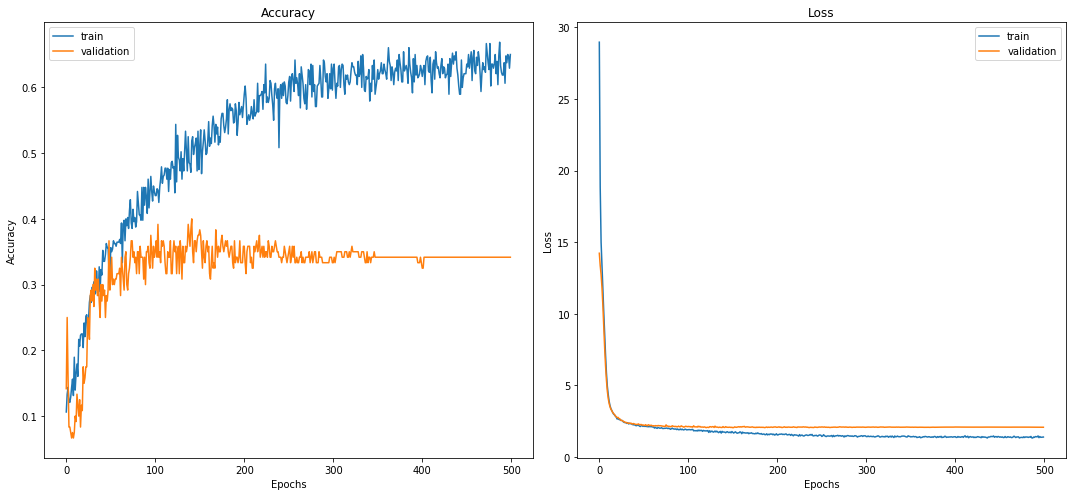

In [106]:
plt.figure(figsize=(15,7))

plt.subplot(1,2,1)
plt.plot(hist.history['accuracy'], label='train')
plt.plot(hist.history['val_accuracy'], label='validation')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(hist.history['loss'], label='train')
plt.plot(hist.history['val_loss'], label='validation')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
def get_model():
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(2, 2), activation='relu', input_shape=(feature_dim_1, feature_dim_2, channel)))
    model.add(Conv2D(64, kernel_size=(2, 2), activation='relu'))
    model.add(Conv2D(128, kernel_size=(2, 2), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.1))
    model.add(Conv2D(256, kernel_size=(2, 2), activation='relu'))
    model.add(Conv2D(512, kernel_size=(2, 2), activation='relu'))
    #model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.1))
    #model.add(Conv2D(1024, kernel_size=(2, 2), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.1))
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy',
                  optimizer='RMSProp',
                  metrics=['accuracy'])
    return model

def get_model2():
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(2, 2), activation='relu', input_shape=(feature_dim_1, feature_dim_2, channel)))
    model.add(Conv2D(64, kernel_size=(2, 2), activation='relu'))
    model.add(MaxPool2D(pool_size=(1, 1)))
    model.add(Dropout(0.2))
    model.add(Conv2D(128, kernel_size=(2, 2), activation='relu'))
    model.add(Conv2D(128, kernel_size=(2, 2), activation='relu'))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    #model.add(MaxPool2D(pool_size=(2, 2), strides=2))
    #model.add(Dropout(0.2))
    #model.add(Conv2D(256, kernel_size=(2, 2), activation='relu'))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(500, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='RMSProp', metrics=['accuracy'])
    
    return model

def get_model3():
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(2, 2), activation='relu', input_shape=(feature_dim_1, feature_dim_2, channel)))
    model.add(Conv2D(64, kernel_size=(2, 2), activation='relu'))
    model.add(Conv2D(128, kernel_size=(2, 2), activation='relu'))
    model.add(MaxPool2D(pool_size=(1, 1)))
    model.add(Dropout(0.5))
    model.add(Conv2D(128, kernel_size=(2, 2), activation='relu'))
    model.add(Conv2D(256, kernel_size=(2, 2), activation='relu'))
    model.add(MaxPool2D(pool_size=(1, 1)))
    model.add(Dropout(0.5))
    model.add(Conv2D(128, kernel_size=(2, 2), activation='relu'))
    model.add(Conv2D(256, kernel_size=(4, 4), activation='relu'))
    model.add(MaxPool2D(pool_size=(2, 2)))
    #model.add(Conv2D(1024, kernel_size=(2, 2), activation='relu'))
    #model.add(Conv2D(512, kernel_size=(2, 2), activation='relu'))
    #model.add(MaxPool2D(pool_size=(2, 2)))
    #model.add(Dropout(0.2))
    #model.add(Conv2D(256, kernel_size=(2, 2), activation='relu'))
    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(256, kernel_regularizer=regularizers.l2(0.2), activation='relu'))
    model.add(Dense(32, kernel_regularizer=regularizers.l2(0.2), activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='RMSProp', metrics=['accuracy'])
    return model

def get_model():
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(2, 2), activation='relu', input_shape=(feature_dim_1, feature_dim_2, channel)))
    model.add(Conv2D(48, kernel_size=(2, 2), activation='relu'))
    model.add(Conv2D(120, kernel_size=(2, 2), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(48, kernel_size=(2, 2), activation='relu'))
    model.add(Conv2D(120, kernel_size=(2, 2), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy',
                  optimizer='RMSProp',
                  metrics=['accuracy'])
    return model

In [62]:
# Handy function to convert wav2mfcc
def wav2mfcc(file_path, max_len=11):
    wave, sr = librosa.load(file_path, mono=True, sr=16000)
    print(wave.shape)
    wave = wave[::3]
    print(wave.shape)
    wave = np.asfortranarray(wave)
    mfcc = librosa.feature.melspectrogram(wave, sr=16000)
    print(mfcc.shape)

    # If maximum length exceeds mfcc lengths then pad the remaining ones
    if (max_len > mfcc.shape[1]):
        pad_width = max_len - mfcc.shape[1]
        mfcc = np.pad(mfcc, pad_width=((0, 0), (0, pad_width)), mode='constant')

    # Else cutoff the remaining parts
    else:
        mfcc = mfcc[:, :max_len]

    return mfcc

In [90]:
# Predicts one sample
def predict(filepath, model):
    sample = wav2mfcc(filepath, 11)[:20]
    sample_reshaped = sample.reshape(1, feature_dim_1, 11, channel)
    print(model.predict(sample_reshaped))
    return get_labels()[0][
            np.argmax(model.predict(sample_reshaped))
    ]

In [91]:
print(predict('../data/test/steady_as_she_goes.wav', model=model))

[[0.08028426 0.15431988 0.10617559 0.08145969 0.08064907 0.08181842
  0.13898131 0.08166382 0.08876195 0.10588601]]
../data/raw/genres/metal


In [92]:
print(predict('../data/test/classic.wav', model=model))

[[0.07937667 0.14586547 0.10391413 0.08291523 0.07898694 0.08395266
  0.14209835 0.0797938  0.09221485 0.11088178]]
../data/raw/genres/metal


In [93]:
print(predict('../data/test/black_math.wav', model=model))

[[0.07856303 0.15567319 0.10634793 0.08140703 0.08108101 0.08118027
  0.13901787 0.0813656  0.08930024 0.10606384]]
../data/raw/genres/metal


In [216]:
GENRES = ('blues', 'pop', 'rock', 'disco', 'hiphop')

In [217]:
def read_wav(file):
    raw_audio = tf.io.read_file(file)
    waveform = tf.audio.decode_wav(raw_audio)
    return waveform.audio.numpy()[:LEN_SONG]

def read_genre(genres):
    _songs = []
    _genre = []
    for idx_genre, genre in enumerate(genres):
        py = pathlib.Path('../data/raw/genres/{g}/'.format(g=genre)).glob("*.wav")
        for file in py:
            _songs.append(read_wav(file.as_posix()))
            _genre.append(idx_genre)
    return _songs, _genre

In [218]:
X, Y = read_genre(GENRES)

In [219]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(Y, len(GENRES))

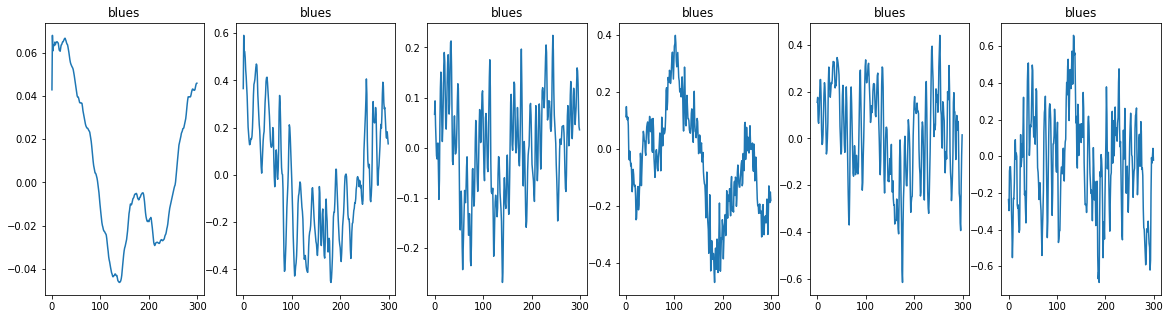

In [220]:
# Visualize raw signal

%matplotlib inline
import matplotlib.cm as cm
import numpy as np

# plot first six training songs
fig = plt.figure(figsize=(20,5))
for i in range(6):
    ax = fig.add_subplot(1, 6, i+1)
    ax.plot(X[i][:300])
    ax.set_title(str(GENRES[Y[i]]))

In [223]:
len(X)

496

In [224]:
x = np.array(X).reshape(496, LEN_SONG)
x.shape

(496, 60000)

In [225]:
batch_size, num_samples, sample_rate = 32, 32000, 16000.0
# A Tensor of [batch_size, num_samples] mono PCM samples in the range [-1, 1].
pcm = x

# A 1024-point STFT with frames of 64 ms and 75% overlap.
stfts = tf.signal.stft(pcm, frame_length=1024, frame_step=256,
                       fft_length=1024)
spectrograms = tf.abs(stfts)
# Warp the linear scale spectrograms into the mel-scale.
num_spectrogram_bins = stfts.shape[-1]
lower_edge_hertz, upper_edge_hertz, num_mel_bins = 80.0, 7600.0, 80
linear_to_mel_weight_matrix = tf.signal.linear_to_mel_weight_matrix(
  num_mel_bins, num_spectrogram_bins, sample_rate, lower_edge_hertz,
  upper_edge_hertz)
mel_spectrograms = tf.tensordot(
  spectrograms, linear_to_mel_weight_matrix, 1)
mel_spectrograms.set_shape(spectrograms.shape[:-1].concatenate(
  linear_to_mel_weight_matrix.shape[-1:]))

# Compute a stabilized log to get log-magnitude mel-scale spectrograms.
log_mel_spectrograms = tf.math.log(mel_spectrograms + 1e-6)

# Compute MFCCs from log_mel_spectrograms and take the first 13.
mfccs = tf.signal.mfccs_from_log_mel_spectrograms(
  log_mel_spectrograms)[..., :13]

In [259]:
mfccs.shape

TensorShape([496, 231, 13])

In [262]:
mfccs = tf.reshape(mfccs, (496, 231, 13, 1))

In [324]:
train_dataset = tf.data.Dataset.from_tensor_slices((mfccs, y))
# Shuffle and slice the dataset.
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(24)
train_dataset

<BatchDataset shapes: ((None, 231, 13, 1), (None, 5)), types: (tf.float32, tf.float32)>

ValueError: x and y can be no greater than 2-D, but have shapes (10,) and (10, 13, 1)

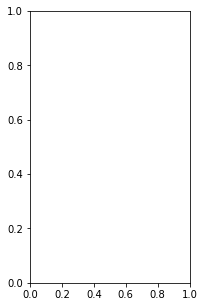

In [326]:
# plot first six training images
fig = plt.figure(figsize=(20,5))
for i in range(6):
    ax = fig.add_subplot(1, 6, i+1)
    ax.plot(mfccs[i][:10])
    ax.set_title(str(GENRES[Y[i]]))

In [327]:
from tensorflow.keras.layers import Dense, Activation, Conv1D, Conv2D, Input, Dropout, \
    Flatten, InputLayer, MaxPool2D, GlobalAveragePooling1D, MaxPool1D
from tensorflow.keras.models import Sequential

model = Sequential()
model.add(Conv2D(128, kernel_size=(2, 2), padding='same', input_shape=(231, 13, 1)))
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.2))
model.add(Conv2D(64, kernel_size=(2, 2), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(128, kernel_size=(2, 2), padding='same'))
model.add(Activation('relu'))
model.add(Dropout(0.2))
#model.add(MaxPool2D(pool_size=(2, 2), strides=2))
#model.add(Dropout(0.2))
#model.add(Conv2D(256, kernel_size=(2, 2), activation='relu'))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(500, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(len(GENRES), activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='RMSProp', metrics=['accuracy'])

In [328]:
from tensorflow.keras.callbacks import ModelCheckpoint
checkpointer = ModelCheckpoint(filepath='tagger6.model.best.hdf5', 
                               verbose=1, save_best_only=True)

In [329]:
import datetime
log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [330]:
model.fit(mfccs, y, epochs=20, callbacks=[tensorboard_callback, checkpointer],
          validation_split=0.2)

Train on 396 samples, validate on 100 samples
Epoch 1/20
384/396 [============================>.] - ETA: 0s - loss: 10.5081 - accuracy: 0.3385
Epoch 00001: val_loss improved from inf to 6.93050, saving model to tagger6.model.best.hdf5
396/396 [==============================] - 12s 29ms/sample - loss: 10.2263 - accuracy: 0.3359 - val_loss: 6.9305 - val_accuracy: 0.0000e+00
Epoch 2/20
384/396 [============================>.] - ETA: 0s - loss: 1.0952 - accuracy: 0.5208
Epoch 00002: val_loss improved from 6.93050 to 6.75287, saving model to tagger6.model.best.hdf5
396/396 [==============================] - 10s 26ms/sample - loss: 1.0887 - accuracy: 0.5253 - val_loss: 6.7529 - val_accuracy: 0.0000e+00
Epoch 3/20
384/396 [============================>.] - ETA: 0s - loss: 1.0372 - accuracy: 0.5495
Epoch 00003: val_loss improved from 6.75287 to 5.92856, saving model to tagger6.model.best.hdf5
396/396 [==============================] - 10s 26ms/sample - loss: 1.0347 - accuracy: 0.5480 - val_los

In [320]:
model.summary()

Model: "sequential_53"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_228 (Conv2D)          (None, 231, 13, 32)       160       
_________________________________________________________________
activation_27 (Activation)   (None, 231, 13, 32)       0         
_________________________________________________________________
max_pooling2d_90 (MaxPooling (None, 115, 6, 32)        0         
_________________________________________________________________
dropout_122 (Dropout)        (None, 115, 6, 32)        0         
_________________________________________________________________
conv2d_229 (Conv2D)          (None, 115, 6, 64)        8256      
_________________________________________________________________
activation_28 (Activation)   (None, 115, 6, 64)        0         
_________________________________________________________________
conv2d_230 (Conv2D)          (None, 115, 6, 128)     

In [331]:
# load the weights that yielded the best validation accuracy
model.load_weights('tagger6.model.best.hdf5')

# evaluate test accuracy
score = model.evaluate(train_dataset, verbose=0)
accuracy = 100*score[1]

# print test accuracy
print('Test accuracy: %.4f%%' % accuracy)

Test accuracy: 59.2742%
